# Evaluation of the variation of the zero temperature condensate fluctuations

## Meier-Zwerger

Equation (10) from Anomalous condensate fluctuations in strongly interacting superfluids, F. Meier and W. Zwerger, Phys. Rev. A 60, 5133 (1999):

$\displaystyle \langle \delta \hat{N}_0^2 \rangle |_{T = 0} \simeq 2 \left( \frac{n_0 (T = 0)}{n} \right)^2 \left( \frac{mc}{2 \hbar} \right)^2 \frac{1}{2 \pi^2} \Lambda V$

where $n_0 (T = 0)$ is the condensate density at zero temperature and $\Lambda$ is the momentum cutoff.

Applied to the context of our lattice experiment, $m$ is replaced by the effective mass $m^*$ and $c$ by the sound velocity in the lattice:

$\displaystyle m^* = \frac{\hbar^2}{2Jd_{\mathrm{latt}}^2}$

where $J$ is the tunnel coupling and $d_{\mathrm{latt}} = 1550 / 2 \ \mathrm{nm}$ is the lattice spacing.
The sound velocity is

$\displaystyle c = \frac{1}{\sqrt{\kappa m^*}}$

with the compressibility given by

$\displaystyle \kappa = \frac{1}{U n_0}$

where $U$ is the onsite interaction and $n_0$ is the condensate density.

The condensate density at zero temperature is assumed to vary according to the critical scaling law:

$\displaystyle n_0 \propto \left( 1 - \frac{U/J}{(U/J)_c} \right)^{2 \beta}$

where $\beta = 0.3485$ for the 3D XY universality class and $(U/J)_c = 25.2(8)$ for the considered datasets.

A quantitative agreement cannot be expected for this formula describing the homogeneous case, therefore the variation of the fluctuations is evaluated in arb. units. The only variables that change for the ground state occupation fluctuations as a function of $U/J$ are thus:

$\displaystyle \langle \delta \hat{N}_0^2 \rangle |_{T = 0} \propto (n_0(T=0)m^*c)^2$

In [1]:
"""SETUP"""

# Standard library imports:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Local imports:
import lattice
from atom import Helium
import phys_constants

# Physical constants:
h = phys_constants.h
hbar = phys_constants.hbar
gHe = phys_constants.gHe
d_latt = phys_constants.d_latt
he = Helium()
m = he.mass
beta = 0.3485
u_c = 26
Er = lattice.recoilenergy(d_latt,m)

# Set up lattice parameters:
n = 0  # Band index
xsampl = np.linspace(-1.5, 1.5, 200)  # Real-space position
size = 100  # Number of lattice sites
qarr = lattice.quasimomenta(size)  # Quasimomenta
sarr = np.linspace(5, 15, 100) # Test values for lattice amplitude

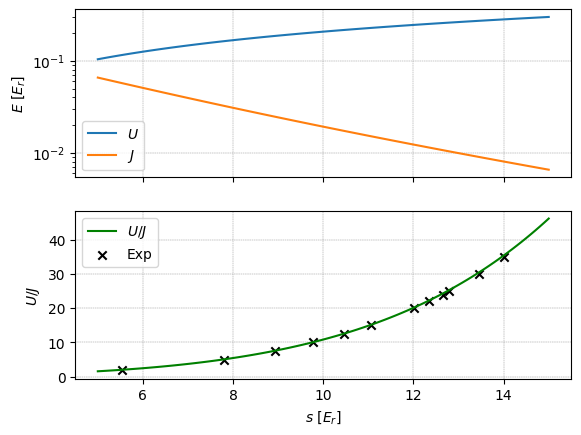

In [2]:
""" Test that lattice amplitude correctly reproduces experimental values"""

# Data input (exp. values of s used for data acquisition):
uj_exp = pd.Series({
    2: 5.5425,
    5: 7.78888,
    7.5: 8.91949,
    10: 9.775,
    12.5: 10.4694,
    15: 11.0568,
    20: 12.0196,
    22: 12.3482,
    24: 12.6522,
    25: 12.7961,
    30: 13.4492,
    35: 14.014,
    })

# Calculate U/J values with lattice script functions:
uj = pd.DataFrame(index=sarr, columns=['U', 'J', 'U/J'], dtype=float)

for s in sarr:

    # Calculate U and J from s:
    e, bs = lattice.eigenproblem(s, qarr, bands=n)
    U = gHe * (lattice.hubbardU(xsampl, bs, scale=d_latt))**3  # Cubic power for 3D problem
    J = Er * lattice.hubbardJ(e, d=1)
    uj.loc[s] = pd.Series({'U': U, 'J': J, 'U/J': U / J})

# Plot results:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].semilogy(
    sarr,
    uj['U'] / Er,
    label=r'$U$'
    )
axs[0].semilogy(
    sarr,
    uj['J'] / Er,
    label=r'$J$'
    )
axs[1].plot(
    sarr,
    uj['U/J'],
    label=r'$U/J$',
    color='g'
    )
axs[1].scatter(
    uj_exp.values,
    uj_exp.index,
    marker='x',
    label='Exp',
    color='k'
    )
axs[-1].set_xlabel(r'$s\ [E_r]$')
axs[0].set_ylabel(r'$E\ [E_r]$')
axs[1].set_ylabel(r'$U/J$')
for ax in axs:
    ax.legend()
    ax.set_axisbelow(True)    
    ax.xaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.yaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.grid(visible=True)
plt.show()

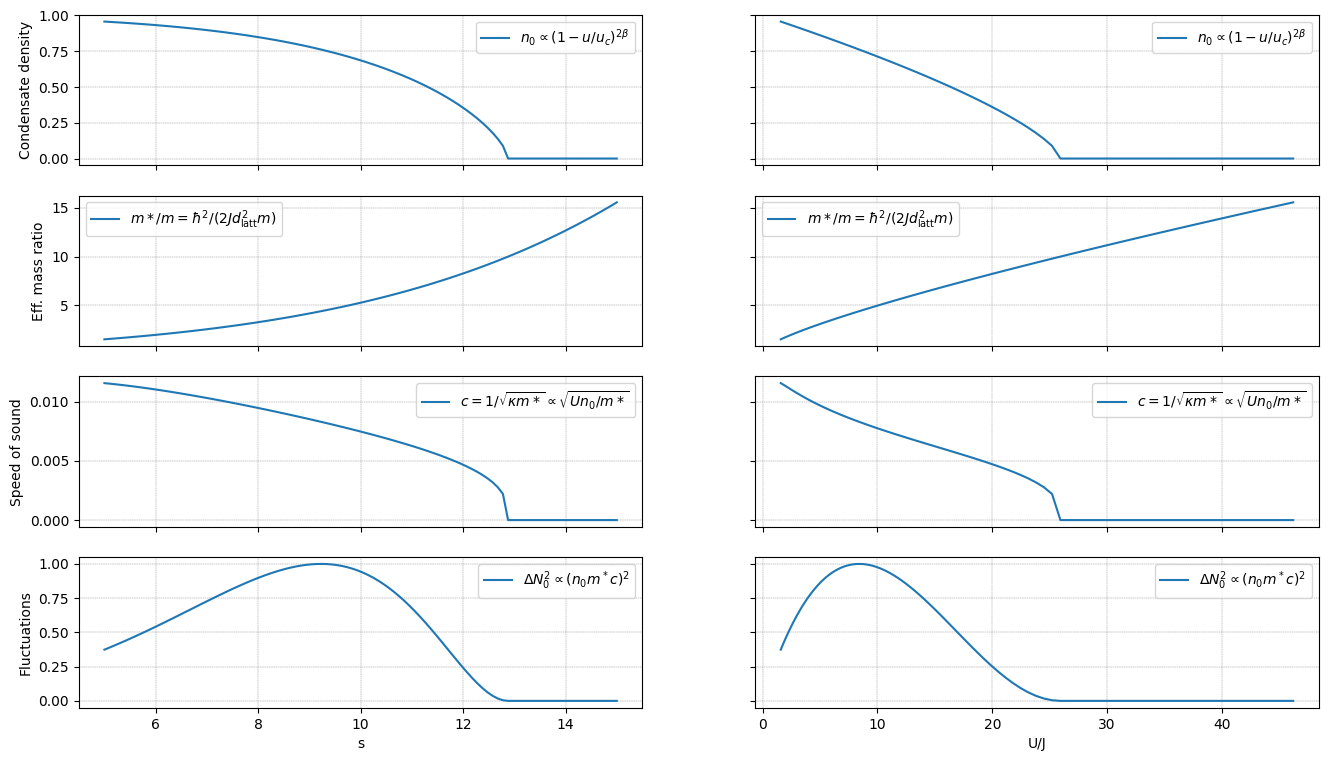

In [3]:
"""Calculate variation of ground state occupation fluctuations with U/J"""

# Calculate quantities for all lattice depths:
fluct_params = pd.DataFrame(index=sarr, columns=['eff_mass', 'n_0', 'comp', 'speed_of_sound', 'fluct'], dtype=float)

for s in sarr:

    # Effective mass:
    fluct_params['eff_mass'].at[s] = hbar**2 / (2 * uj['J'].loc[s] * d_latt**2)
    # Condensate density:
    if uj.loc[uj['U/J']<=u_c].index.max() > s:
        fluct_params['n_0'].at[s] = (1 - uj['U/J'].loc[s] / u_c)**(2 * beta)
    else:
        fluct_params['n_0'].at[s] = 1e-10
    # Compressibility:
    fluct_params['comp'].at[s] = 1 / (uj['U'].loc[s] * fluct_params['n_0'].loc[s])
    # Speed of sound:
    fluct_params['speed_of_sound'].at[s] = 1 / np.sqrt(fluct_params['comp'].loc[s] * fluct_params['eff_mass'].loc[s])
    # Fluctuations:
    fluct_params['fluct'].at[s] = (fluct_params['n_0'].loc[s] * fluct_params['eff_mass'].loc[s] * fluct_params['speed_of_sound'].loc[s])**2

# Plot results as a function of s and of U/J:
fig, axs = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(16, 9))

for col_idx, x_ax in enumerate([sarr, uj['U/J']]):
    axs[0][col_idx].plot(
        x_ax,
        fluct_params['n_0'],
        label=r'$n_0 \propto (1-u/u_c)^{2\beta}$'
        )    
    axs[1][col_idx].plot(
        x_ax,
        fluct_params['eff_mass'] / m,
        label=r'$m*/m = \hbar ^2 / (2 J d_{\mathrm{latt}}^2 m)$'
        )
    axs[2][col_idx].plot(
        x_ax,
        fluct_params['speed_of_sound'],
        label=r'$c = 1 / \sqrt{\kappa m*} \propto \sqrt{U n_0 / m*}$'
        )
    axs[3][col_idx].plot(
        x_ax,
        fluct_params['fluct']/fluct_params['fluct'].max(),
        label=r'$\Delta N_0^2 \propto (n_0m^*c)^2$'
        )
    if col_idx == 0:
        axs[-1][col_idx].set_xlabel('s')
        axs[0][col_idx].set_ylabel('Condensate density')
        axs[1][col_idx].set_ylabel('Eff. mass ratio')
        axs[2][col_idx].set_ylabel('Speed of sound')
        axs[3][col_idx].set_ylabel('Fluctuations')
    elif col_idx == 1:
        axs[-1][col_idx].set_xlabel('U/J')
for ax in axs.flatten():
    ax.legend()
    ax.set_axisbelow(True)    
    ax.xaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.yaxis.grid(color='gray', linestyle='dashed', linewidth=0.3)
    ax.grid(visible=True)

plt.show()